# San Francisco Crime Classification

## Library import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline

import folium

# import geopandas as gpd
# from shapely.geometry import Point
# from geopandas import GeoDataFrame


## Parameter definition

In [2]:
RAW_DATA = '../data/raw/' 
EXTERNAL_DATA = '../data/external/' 
INTERIM_DATA = '../data/interim/' 
PROCESSED_DATA = '../data/processed/'
REFERENCES = '../references/'
RANDOM_STATE = 14

## Data fields

Data fields
 - Dates - timestamp of the crime incident
 - **Category - category of the crime incident (only in train.csv). This is the target variable you are going to predict.**
 - **Descript - detailed description of the crime incident (only in train.csv)**
 - DayOfWeek - the day of the week
 - PdDistrict - name of the Police Department District
 - **Resolution - how the crime incident was resolved (only in train.csv)**
 - Address - the approximate street address of the crime incident 
 - X - Longitude
 - Y - Latitude

Public holidays in San Francisco

 - New Year's Day: 1st January.
 - Martin Luther King Jr Day: Third Monday of January.
 - Presidents' Day: Third Monday in February.
 - Memorial Day: Last Monday in May.
 - Independence Day: 4th July.
 - Labor Day: First Monday in September.
 - Columbus Day: Second Monday in October.
 - Veterans' Day: 11th November.
 - Thanksgiving: Last Thursday in November.
 - Christmas Day: 25th December.

## Learning dataset

In [3]:
df = pd.read_csv(RAW_DATA + 'train.csv')
df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dates       878049 non-null  object 
 1   Category    878049 non-null  object 
 2   Descript    878049 non-null  object 
 3   DayOfWeek   878049 non-null  object 
 4   PdDistrict  878049 non-null  object 
 5   Resolution  878049 non-null  object 
 6   Address     878049 non-null  object 
 7   X           878049 non-null  float64
 8   Y           878049 non-null  float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


In [5]:
df.isna().sum()

Dates         0
Category      0
Descript      0
DayOfWeek     0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
dtype: int64

There is no null value on train dataset.

In [6]:
df.duplicated().sum()

2323

In [7]:
df.drop_duplicates(keep='first', inplace=True)
df

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541
...,...,...,...,...,...,...,...,...,...
878044,2003-01-06 00:15:00,ROBBERY,ROBBERY ON THE STREET WITH A GUN,Monday,TARAVAL,NONE,FARALLONES ST / CAPITOL AV,-122.459033,37.714056
878045,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,INGLESIDE,NONE,600 Block of EDNA ST,-122.447364,37.731948
878046,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,SOUTHERN,NONE,5TH ST / FOLSOM ST,-122.403390,37.780266
878047,2003-01-06 00:01:00,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Monday,SOUTHERN,NONE,TOWNSEND ST / 2ND ST,-122.390531,37.780607


In [8]:
for c in df.columns:
    print(c)
    print(df[c].value_counts())
    print('--'*40)

Dates
2011-01-01 00:01:00    185
2006-01-01 00:01:00    133
2012-01-01 00:01:00     92
2007-06-01 00:01:00     60
2006-01-01 12:00:00     60
                      ... 
2007-11-27 16:09:00      1
2007-11-27 16:04:00      1
2007-11-27 16:03:00      1
2007-11-27 16:00:00      1
2009-02-19 08:00:00      1
Name: Dates, Length: 389257, dtype: int64
--------------------------------------------------------------------------------
Category
LARCENY/THEFT                  174320
OTHER OFFENSES                 125960
NON-CRIMINAL                    91915
ASSAULT                         76815
DRUG/NARCOTIC                   53919
VEHICLE THEFT                   53706
VANDALISM                       44581
WARRANTS                        42145
BURGLARY                        36600
SUSPICIOUS OCC                  31394
MISSING PERSON                  25669
ROBBERY                         22988
FRAUD                           16637
FORGERY/COUNTERFEITING          10592
SECONDARY CODES                  

In [9]:
df.describe()

,X,Y
count,875726.000000,875726.000000
mean,-122.422623,37.771032
std,0.030363,0.457497
min,-122.513642,37.707879
25%,-122.432952,37.752427
50%,-122.416446,37.775421
75%,-122.406959,37.784380
max,-120.500000,90.000000


In [10]:
sum(df['Resolution'] == 'NONE')/len(df['Resolution'])*100

59.96418971230727

In [11]:
len(df['Category'].unique())

39

#TODO: create a summary with first impressions on dataset

- At Resolution column almost 60% of the data is NONE.
- There are 39 uniques types of Category.
- 9 categories correspond to more than 80 of the crimes. 

## Date in dataset

**Transforming Dates column from object to datetime**

In [12]:
df['Dates'] = pd.to_datetime(df['Dates'])
df['Dates']

0        2015-05-13 23:53:00
1        2015-05-13 23:53:00
2        2015-05-13 23:33:00
3        2015-05-13 23:30:00
4        2015-05-13 23:30:00
                 ...        
878044   2003-01-06 00:15:00
878045   2003-01-06 00:01:00
878046   2003-01-06 00:01:00
878047   2003-01-06 00:01:00
878048   2003-01-06 00:01:00
Name: Dates, Length: 875726, dtype: datetime64[ns]

In [13]:
#df['month'] = df['Dates'].apply(lambda dt: dt.month)
#df['day'] = df['Dates'].apply(lambda dt: dt.day)
#df['year'] = df['Dates'].apply(lambda dt: dt.year)
#df

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 875726 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Dates       875726 non-null  datetime64[ns]
 1   Category    875726 non-null  object        
 2   Descript    875726 non-null  object        
 3   DayOfWeek   875726 non-null  object        
 4   PdDistrict  875726 non-null  object        
 5   Resolution  875726 non-null  object        
 6   Address     875726 non-null  object        
 7   X           875726 non-null  float64       
 8   Y           875726 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 66.8+ MB


In [15]:
df['month'] = df['Dates'].dt.month
df['day'] = df['Dates'].dt.day
df['year'] = df['Dates'].dt.year
df['hour'] = df['Dates'].dt.hour
#df['minute'] = df['Dates'].dt.minute
#df['time'] = df['Dates'].dt.time
df

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,month,day,year,hour
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,5,13,2015,23
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,5,13,2015,23
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,5,13,2015,23
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,5,13,2015,23
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,5,13,2015,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...
878044,2003-01-06 00:15:00,ROBBERY,ROBBERY ON THE STREET WITH A GUN,Monday,TARAVAL,NONE,FARALLONES ST / CAPITOL AV,-122.459033,37.714056,1,6,2003,0
878045,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,INGLESIDE,NONE,600 Block of EDNA ST,-122.447364,37.731948,1,6,2003,0
878046,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,SOUTHERN,NONE,5TH ST / FOLSOM ST,-122.403390,37.780266,1,6,2003,0
878047,2003-01-06 00:01:00,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Monday,SOUTHERN,NONE,TOWNSEND ST / 2ND ST,-122.390531,37.780607,1,6,2003,0


In [16]:
#Creating morning, afternoon, night and dawn
# condlist = [df['hour']<6, df['hour']<12, df['hour']<18]
# choicelist = ['dawn', 'morning', 'afternoon']
# df['day_period'] = np.select(condlist, choicelist, 'night')
# df['day_period'].value_counts()

In [17]:
df.iloc[582]

Dates                          2015-05-12 11:30:00
Category                             LARCENY/THEFT
Descript              GRAND THEFT FROM LOCKED AUTO
DayOfWeek                                  Tuesday
PdDistrict                                 CENTRAL
Resolution                                    NONE
Address       SANSOME ST / THE EMBARCADERONORTH ST
X                                      -122.403592
Y                                        37.805413
month                                            5
day                                             12
year                                          2015
hour                                            11
Name: 583, dtype: object

In [18]:
def visualization_crime(value, tight=False):
    with plt.style.context('fivethirtyeight'):
        fig, ax = plt.subplots(1, 1, figsize=(19, 6))
        sns.histplot(x=value, data=df, kde=False, palette='rocket', ax=ax)
        ax.tick_params(axis='x', rotation=0)
        if tight == True:
            fig.tight_layout()

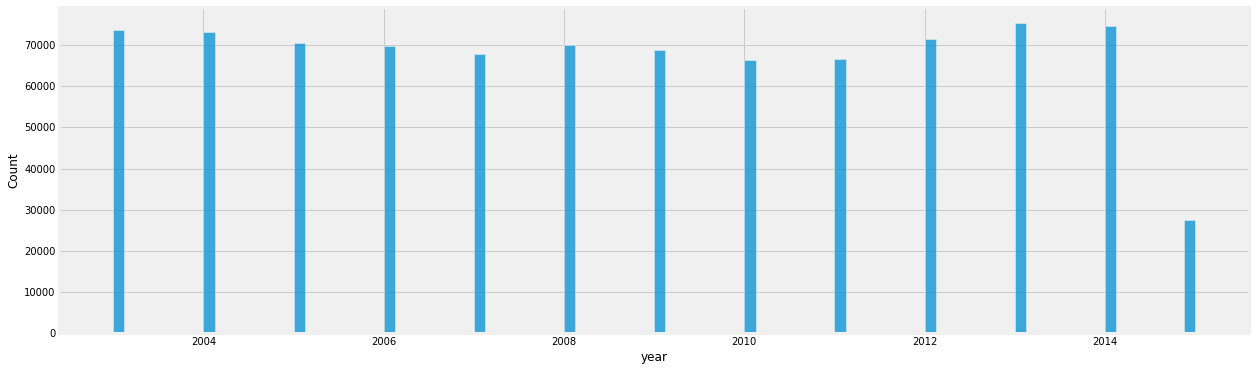

In [19]:
visualization_crime('year')

## Day of week

In [20]:
df['DayOfWeek'].value_counts()

Friday       133371
Wednesday    128829
Saturday     126469
Thursday     124757
Tuesday      124603
Monday       121303
Sunday       116394
Name: DayOfWeek, dtype: int64

#TODO: what information can I get from day of week?

## Category

In [21]:
df['Category'].value_counts()

LARCENY/THEFT                  174320
OTHER OFFENSES                 125960
NON-CRIMINAL                    91915
ASSAULT                         76815
DRUG/NARCOTIC                   53919
VEHICLE THEFT                   53706
VANDALISM                       44581
WARRANTS                        42145
BURGLARY                        36600
SUSPICIOUS OCC                  31394
MISSING PERSON                  25669
ROBBERY                         22988
FRAUD                           16637
FORGERY/COUNTERFEITING          10592
SECONDARY CODES                  9979
WEAPON LAWS                      8550
PROSTITUTION                     7446
TRESPASS                         7318
STOLEN PROPERTY                  4537
SEX OFFENSES FORCIBLE            4380
DISORDERLY CONDUCT               4313
DRUNKENNESS                      4277
RECOVERED VEHICLE                3132
KIDNAPPING                       2340
DRIVING UNDER THE INFLUENCE      2268
LIQUOR LAWS                      1899
RUNAWAY     

## Address

In [22]:
df['Address'].unique()

array(['OAK ST / LAGUNA ST', 'VANNESS AV / GREENWICH ST',
       '1500 Block of LOMBARD ST', ..., '300 Block of JOHN F KENNEDY DR',
       'FOLSOM ST / ZENO PL', '1000 Block of 22ND AV'], dtype=object)

In [23]:
data = pd.DataFrame(df['Address'].value_counts().values.cumsum(axis=0)/df['Address'].value_counts().values.sum()*100)
data

,0
0,2.996942
1,3.747862
2,4.329551
3,4.791567
4,5.162117
...,...
23223,99.999543
23224,99.999657
23225,99.999772
23226,99.999886


In [24]:
df['Address'].value_counts()

800 Block of BRYANT ST           26245
800 Block of MARKET ST            6576
2000 Block of MISSION ST          5094
1000 Block of POTRERO AV          4046
900 Block of MARKET ST            3245
                                 ...  
INTERSTATE280 HY / OCEAN AV          1
23RD ST / GRANDVIEW AV               1
100 Block of RICKARD ST              1
MILTON I ROSS ST / JERROLD AV        1
19TH ST / 3RD ST                     1
Name: Address, Length: 23228, dtype: int64

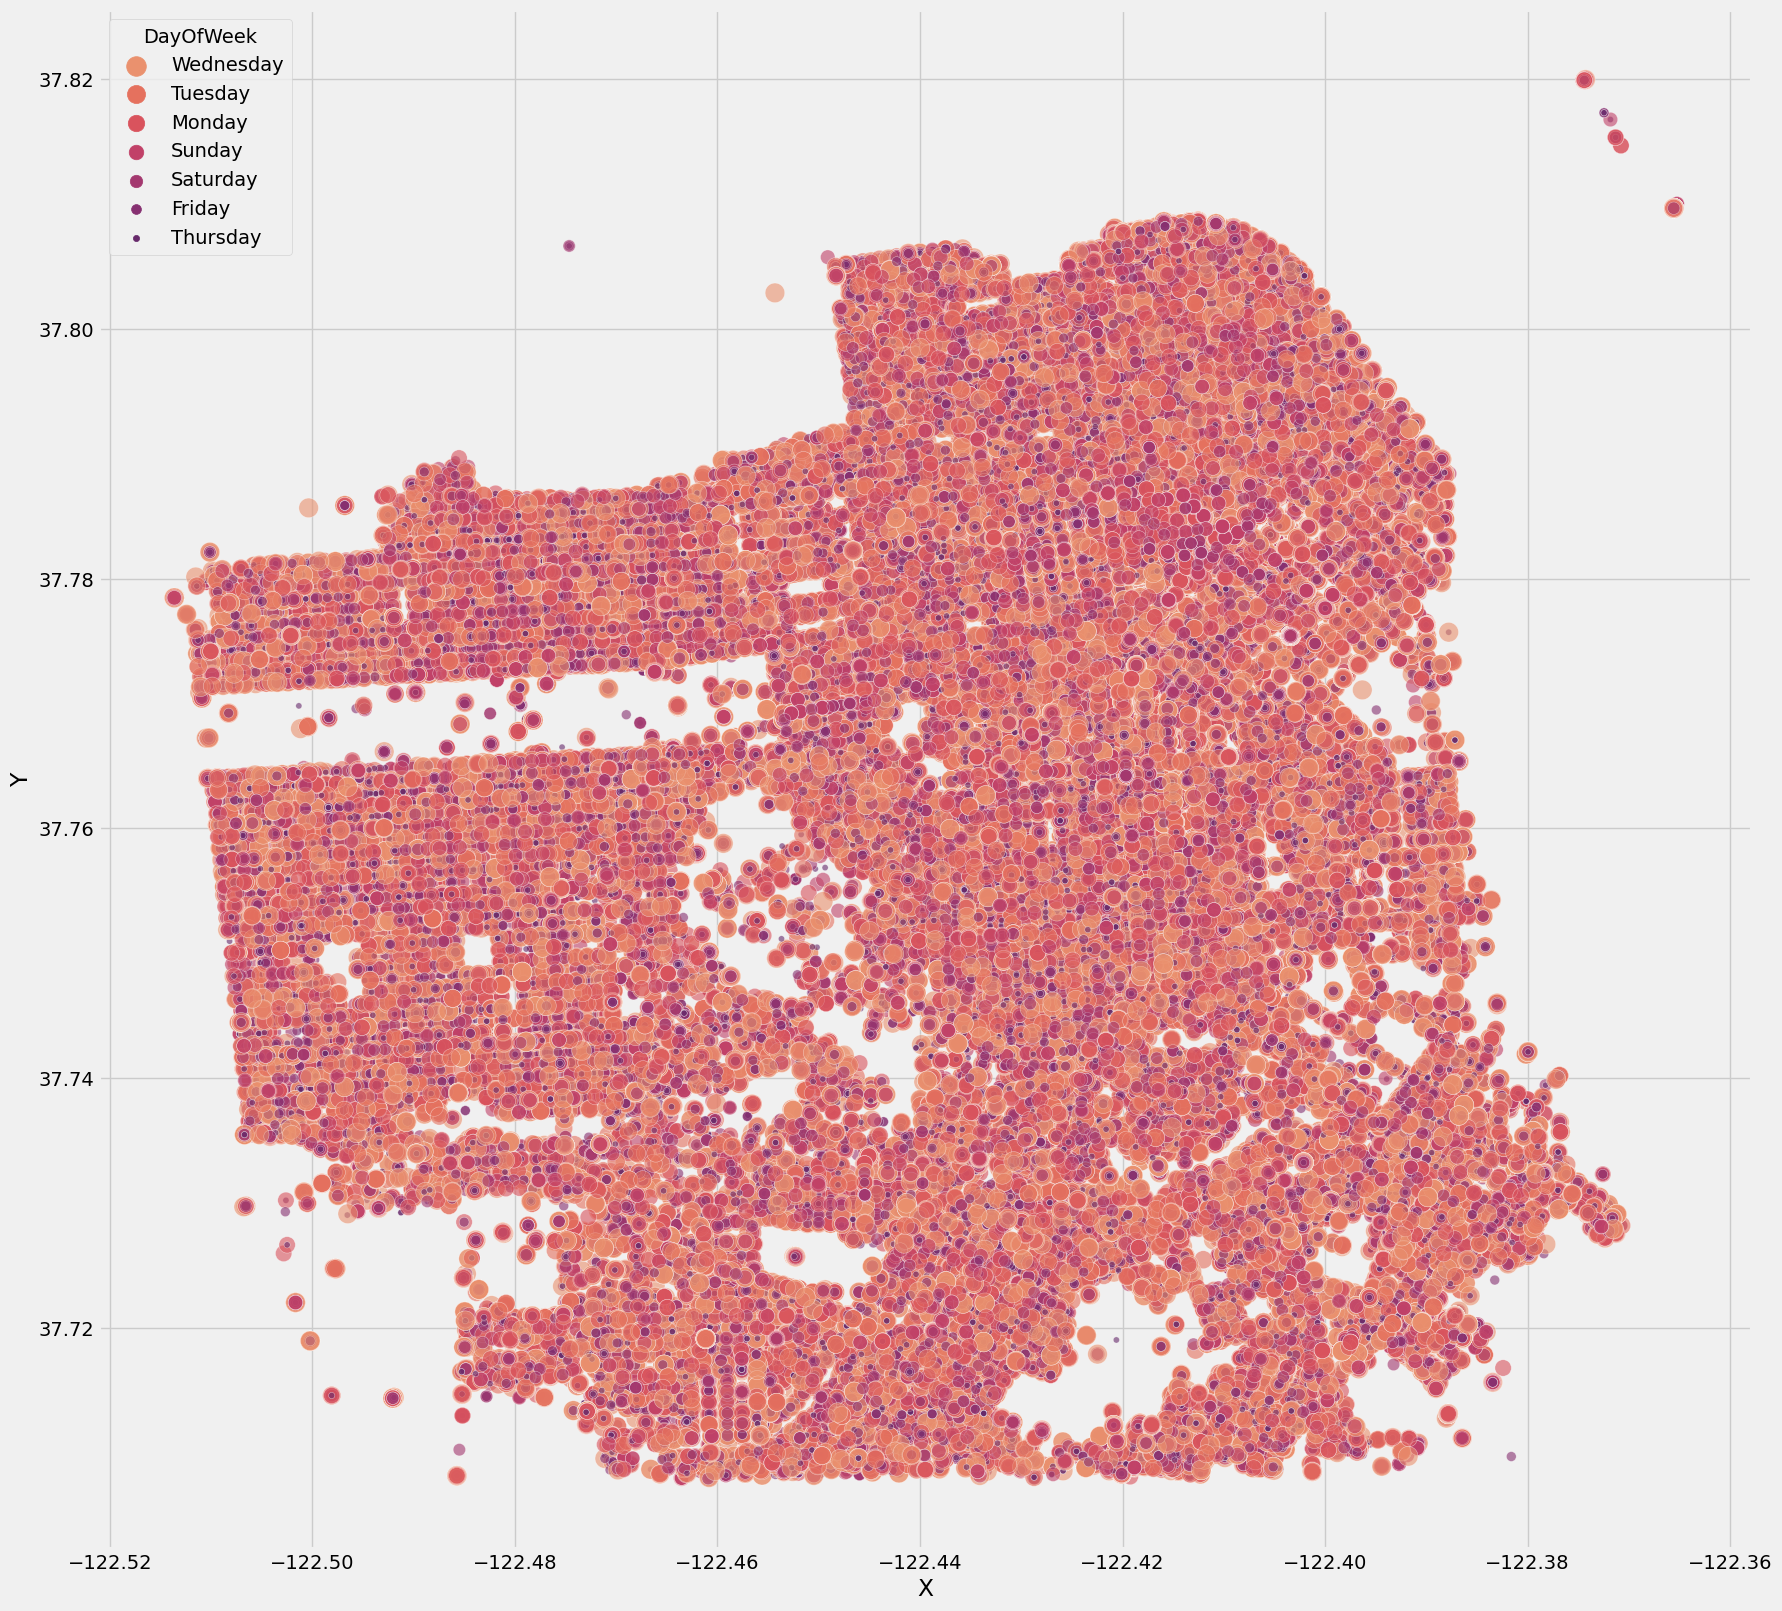

In [25]:
with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(1, 1, figsize=(19, 19))
    sns.scatterplot(data=df.iloc[:500000], x='X', y='Y', alpha=0.6, palette='flare', hue='DayOfWeek',
                    size='DayOfWeek', sizes=(20, 200), markers=True) # 878049

In [26]:
# df['Weekend'] = np.where((df['DayOfWeek']=='Sunday')|(df['DayOfWeek']=='Saturday'), 1, 0)
# df.head(100)

In [27]:
# print(df['Weekend'].value_counts()[0]/5, df['Weekend'].value_counts()[1]/2)

## Latitude (y) and longitude (x)

San Francisco Latitude and longitude coordinates are: 37.773972, -122.431297

 - southernmost position: 37.708086
 - northernmost position: 37.811324
 - westernmost position: -122.514675
 - easternmost position: -122.356859
 
 Source: Google Maps

In [28]:
df[['X', 'Y']].describe()

,X,Y
count,875726.000000,875726.000000
mean,-122.422623,37.771032
std,0.030363,0.457497
min,-122.513642,37.707879
25%,-122.432952,37.752427
50%,-122.416446,37.775421
75%,-122.406959,37.784380
max,-120.500000,90.000000


In [29]:
# df_outliers = df.copy()
# df_outliers

In [30]:
# outliers = (df['X'] > -122.35)|(df['Y'] > 37.82)
# df_outliers.loc[outliers, ['X', 'Y']] = np.nan
# #df.info()
# outliers.value_counts()

In [31]:
# df_outliers.info()

In [32]:
# df_outliers.query('X>-122')

In [33]:
# df_outliers.info()

In [34]:
# geometry = [Point(xy) for xy in zip(train_data['X'], train_data['Y'])]
# gdf = GeoDataFrame(train_data, geometry=geometry)

# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# gdf.plot(ax=world.plot(), marker='o', color='red')
# plt.show()

In [35]:
# m = folium.Map(location=[37.75, -122.45], zoom_start=12, tiles= 'Stamen Toner')

# folium.CircleMarker(
#     location=[37.780165, -122.403068],
#     radius=100,
#     popup=f'SOUTHERN\nLARCENY/THEFT',
#     color='blue',
#     fill=True,
#     fill_color='lightblue'
# ).add_to(m)

# m

## Exporting dataset

In [36]:
df.drop('Dates', axis=1, inplace=True)
df

,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,month,day,year,hour
0,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,5,13,2015,23
1,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,5,13,2015,23
2,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,5,13,2015,23
3,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,5,13,2015,23
4,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,5,13,2015,23
...,...,...,...,...,...,...,...,...,...,...,...,...
878044,ROBBERY,ROBBERY ON THE STREET WITH A GUN,Monday,TARAVAL,NONE,FARALLONES ST / CAPITOL AV,-122.459033,37.714056,1,6,2003,0
878045,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,INGLESIDE,NONE,600 Block of EDNA ST,-122.447364,37.731948,1,6,2003,0
878046,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,SOUTHERN,NONE,5TH ST / FOLSOM ST,-122.403390,37.780266,1,6,2003,0
878047,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Monday,SOUTHERN,NONE,TOWNSEND ST / 2ND ST,-122.390531,37.780607,1,6,2003,0


In [37]:
df.to_parquet(INTERIM_DATA + 'train.pqt', index=False)